In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
import random
#import keras_tuner as kt


### Cargue de los datos

In [3]:
# Cargar archivos (rutas relativas desde notebooks/)
train = pd.read_csv("../data/raw/train_data.csv")
test = pd.read_csv("../data/raw/test_data.csv")
sample_submission = pd.read_csv("../data/raw/sampleSubmission.csv")

## Ingenieria de variables

In [4]:
def extend_features(df): 
    # RATIOS COMBINADOS Y COMPUESTOS
    # Z-score modificado (versión de Altman para no manufactureras):
    # Versión modificada del Z-score (simplificado)
    df['Z_score_modificado'] = (
        1.2 * df['Working.Capital.to.Total.Assets'] +
        1.4 * df['Retained.Earnings.to.Total.Assets'] +
        3.3 * df['Operating.Profit.Rate'] +
        0.6 * df['Equity.to.Liability'] +
        1.0 * df['Revenue.per.person']  # Ajustado como proxy de ventas/activos
    )

    # Ratio de apalancamiento extendido
    df['Apalancamiento_Extendido'] = df['Total.debt.Total.net.worth'] + df['Contingent.liabilities.Net.worth']

    # DIFERENCIAS Y VARIACIONES TEMPORALES
    # Cambio en margen bruto vs margen operativo (eficiencia operativa)
    df['Cambio_Margen_Bruto'] = df['Gross.Profit.to.Sales'] - df['Operating.Gross.Margin']

    # INDICADORES DE SOLVENCIA Y ESTRES FINANCIERO
    # Indicador de estrés financiero: pasivos corrientes vs activos líquidos
    df['Stress_Financiero'] = df['Current.Liability.to.Current.Assets'] / (df['Cash.Total.Assets'] + 1e-6)

    # 4. Relación de liquidez con obligaciones: flujo de caja vs pasivos
    df['Liquidez_vs_Pasivos'] = df['Cash.Flow.to.Liability'] - df['Interest.Coverage.Ratio..Interest.expense.to.EBIT.']

    # 5. Bandera de alerta si flujo operativo es bajo y ratio de deuda alto
    df['Bandera_Bajo_Flujo_Operativo'] = np.where(
        (df['Cash.Flow.to.Sales'] < 0.05) & (df['Debt.ratio..'] > 0.7),
        1, 0
    )

    # 6. Variación de utilidad por acción entre temporadas (estabilidad)
    df['Volatilidad_EPS'] = df['Persistent.EPS.in.the.Last.Four.Seasons'].rolling(window=4, min_periods=1).std()

    # 7. Margen de beneficio después de impuestos
    df['Margen_Neto_Post_Impuestos'] = df['After.tax.Net.Profit.Growth.Rate'] / (df['Operating.Profit.Rate'] + 1e-6)

    # 8. Ratio de cobertura de obligaciones financieras
    df['Cobertura_Deuda'] = df['Operating.Profit.Rate'] / (df['Interest.bearing.debt.interest.rate'] + 1e-6)

    # 9. Capital de trabajo neto sobre activos totales
    df['Capital_Trabajo_Ratio'] = (df['Current.Assets.Total.Assets'] - df['Current.Liability.to.Assets'])
    
    return df

In [5]:
# Agregar nuevas variables
train = extend_features(train)
test = extend_features(test)

#### Verificación de valores vacios
Porque se crearon nuevas variables

In [6]:
# Porcentaje de valores nulos por columna
nulls = train.isnull().mean().sort_values(ascending=False)
nulls[nulls > 0]

Volatilidad_EPS    0.000488
dtype: float64

In [7]:
# Porcentaje de valores nulos por columna
nulls = test.isnull().mean().sort_values(ascending=False)
nulls[nulls > 0]

Volatilidad_EPS    0.002
dtype: float64

In [8]:
from sklearn.impute import SimpleImputer

# Separar features y target para que al imputar tengan las mismas columnas
X = train.drop(columns=["ID", "Bankruptcy"])
y = train["Bankruptcy"]

# Guardar ID del test para el submission
test_ids = test["ID"]
X_test = test.drop(columns=["ID"])

# Asegurarse de que X_test tenga las mismas columnas que X
X_test = X_test.reindex(columns=X.columns, fill_value=np.nan)

# Crear el imputer para la mediana
median_imputer = SimpleImputer(strategy='median')

# Aplicar el imputer a los datos de entrenamiento y prueba
X_train_imputed = pd.DataFrame(median_imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(median_imputer.transform(X_test), columns=X.columns)

### División y normalización de los datos

In [9]:
# Dividir training en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_imputed, y, test_size=0.2, stratify=y, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_imputed)

#X_train_scaled[:3]  # Mostrar ejemplo de datos escalados

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Entrenar el modelo
rf_model.fit(X_train_scaled, y_train)

# Predecir en validación
y_val_pred = rf_model.predict(X_val_scaled)
y_val_prob = rf_model.predict_proba(X_val_scaled)[:, 1]

# Evaluación
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_prob))

Confusion Matrix:
 [[397   1]
 [ 12   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       398
           1       0.00      0.00      0.00        12

    accuracy                           0.97       410
   macro avg       0.49      0.50      0.49       410
weighted avg       0.94      0.97      0.96       410

ROC AUC Score: 0.9163525963149078


El modelo está clasificando muy bien la clase 0 (no quiebra), pero no está identificando ningún caso de la clase 1 (quiebra), lo que es típico en datasets desbalanceados

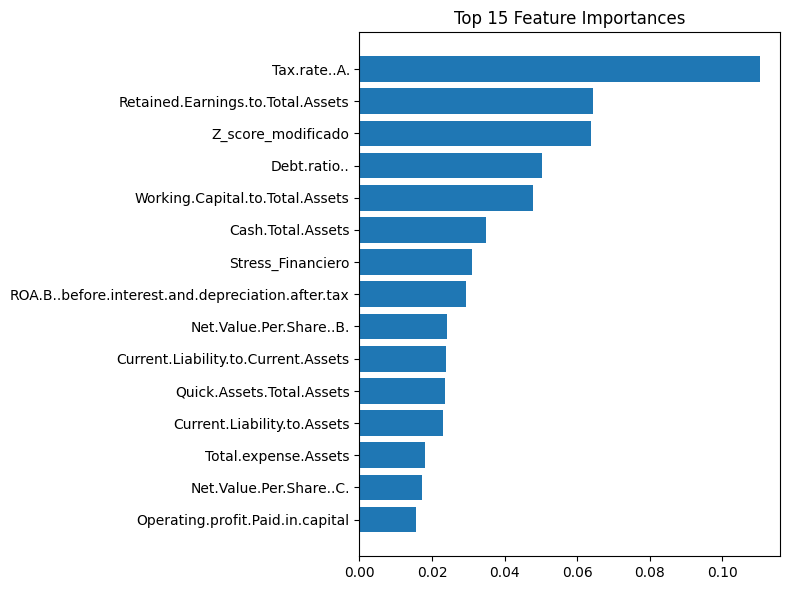

In [ ]:
import matplotlib.pyplot as plt

# Obtener importancia de las variables
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[-15:]  # top 15

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

### Obtener importancia de las variables

   feature_code  weight_importance                              feature_name
48          f56               23.0           Working.Capital.to.Total.Assets
42          f47               21.0         Retained.Earnings.to.Total.Assets
12          f13               21.0                         Cash.Total.Assets
47          f53               18.0  Per.Share.Net.profit.before.tax..Yuan...
18          f19               17.0                       Equity.to.Liability
..          ...                ...                                       ...
35          f38                2.0               Realized.Sales.Gross.Margin
13          f14                2.0                 Inventory.Working.Capital
7            f8                2.0                 Total.assets.to.GNP.price
33          f36                1.0          After.tax.Net.Profit.Growth.Rate
60          f70                1.0                Margen_Neto_Post_Impuestos

[63 rows x 3 columns]
Matriz de Confusión:
[[396   2]
 [ 11   1]]
Reporte d

c:\Users\Usuario\anaconda3\envs\tf\lib\site-packages\xgboost\core.py:729: UserWarning: [15:58:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


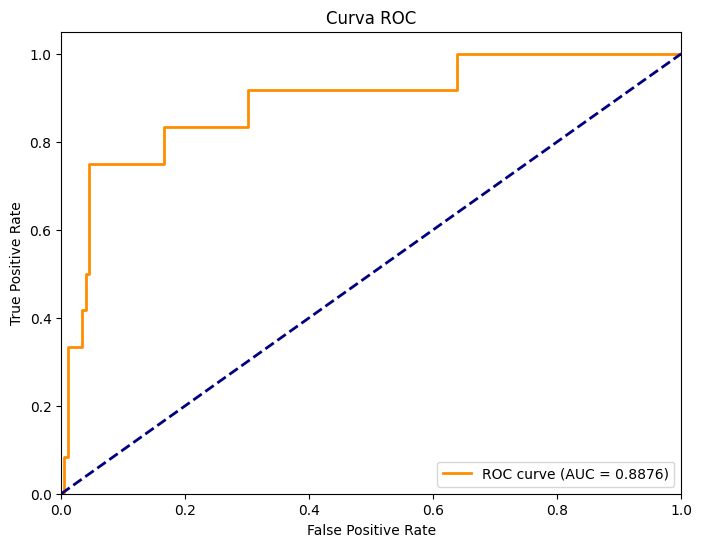

In [11]:
from xgboost import XGBClassifier
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Entrenar el modelo
xgb_model = XGBClassifier(random_state=42, tree_method="hist", device="cuda", eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# 2. Obtener la importancia por 'weight' (veces que se usó la feature para dividir)
feature_important = xgb_model.get_booster().get_score(importance_type='weight')

# 3. Extraer claves (f0, f1, ...) y valores
keys = list(feature_important.keys())
values = list(feature_important.values())

# 4. Crear el DataFrame
importance_df = pd.DataFrame({
    'feature_code': keys,
    'weight_importance': values
})

# 5. Mapear de f0, f1, ... a los nombres reales de las columnas
feature_map = {f"f{i}": col for i, col in enumerate(X.columns)}
importance_df['feature_name'] = importance_df['feature_code'].map(feature_map)

# 6. Ordenar por importancia
importance_df = importance_df.sort_values(by='weight_importance', ascending=False)

# Mostrar importancia de las features
print(importance_df)

# 7. Predicción sobre el set de validación
y_pred = xgb_model.predict(X_val_scaled)

# 8. Evaluación del modelo

# a) Matriz de Confusión
conf_matrix = confusion_matrix(y_val, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# b) Reporte de Clasificación
class_report = classification_report(y_val, y_pred)
print("Reporte de Clasificación:")
print(class_report)

# c) ROC AUC Score
roc_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# d) Curva ROC
fpr, tpr, thresholds = roc_curve(y_val, xgb_model.predict_proba(X_val_scaled)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # <--- Importar SMOTE
import pandas as pd
import numpy as np

# Umbrales de importancia a probar
thresholds = [5, 7, 9, 10, 11, 14, 18, 20]

# Tabla donde guardar resultados
results = []

# Bucle por cada umbral
for threshold in thresholds:
    print(f"\n===> UMBRAL {threshold}")

    # Filtrar las variables que superan el umbral
    selected_features = importance_df[importance_df['weight_importance'] > threshold]['feature_name'].tolist()

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train_imputed.columns)

    # Subconjunto de datos con esas variables
    X_train_sub = X_train_scaled_df[selected_features]
    X_valid_sub = X_val_scaled_df[selected_features]

    # Aplicar SMOTE para balancear clases en el conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train_sub, y_train)

    # Entrenar modelo
    model = XGBClassifier(random_state=42, tree_method="hist", device="cuda", eval_metric='logloss')
    model.fit(X_train_bal, y_train_bal)

    # Predicciones
    y_pred = model.predict(X_valid_sub)
    y_proba = model.predict_proba(X_valid_sub)[:, 1]

    # Evaluaciones
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    print("F1 Score:", round(f1, 4))
    print("ROC AUC:", round(auc, 4))

    print("\nMatriz de confusión:")
    print(confusion_matrix(y_val, y_pred))

    print("\nReporte de clasificación:")
    print(classification_report(y_val, y_pred, digits=4))

    # Guardar resultado
    results.append({
        'Threshold': threshold,
        'Num_Features': len(selected_features),
        'F1_Score': round(f1, 4),
        'ROC_AUC': round(auc, 4)
    })

# Convertir a DataFrame y mostrar ordenado por AUC
results_df = pd.DataFrame(results).sort_values(by='ROC_AUC', ascending=False)
print("\n===== RESULTADOS FINALES =====")
print(results_df)



===> UMBRAL 5
F1 Score: 0.4286
ROC AUC: 0.8698

Matriz de confusión:
[[388  10]
 [  6   6]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9848    0.9749    0.9798       398
           1     0.3750    0.5000    0.4286        12

    accuracy                         0.9610       410
   macro avg     0.6799    0.7374    0.7042       410
weighted avg     0.9669    0.9610    0.9637       410


===> UMBRAL 7
F1 Score: 0.3478
ROC AUC: 0.9039

Matriz de confusión:
[[391   7]
 [  8   4]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9799    0.9824    0.9812       398
           1     0.3636    0.3333    0.3478        12

    accuracy                         0.9634       410
   macro avg     0.6718    0.6579    0.6645       410
weighted avg     0.9619    0.9634    0.9626       410


===> UMBRAL 9
F1 Score: 0.3636
ROC AUC: 0.9139

Matriz de confusión:
[[392   6]
 [  8   4]]

Reporte de c

Mejora haciendo oversampling, y con 40 variables se obtienen los mejores resultados en F1 Score, mientras que con 25 variables se tienen los mejores resultados de AUC.

### Redes Neuronales

In [66]:
# Filtrar las variables que superan el umbral de 5 de importancia
threshold = 5
selected_features = importance_df[importance_df['weight_importance'] > threshold]['feature_name'].tolist()

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train_imputed.columns)

# Subconjunto de datos con esas variables
X_train_sub = X_train_scaled_df[selected_features]
X_valid_sub = X_val_scaled_df[selected_features]

# Aplicar SMOTE para balancear clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_sub, y_train)

In [72]:
selected_features

['Working.Capital.to.Total.Assets',
 'Retained.Earnings.to.Total.Assets',
 'Cash.Total.Assets',
 'Per.Share.Net.profit.before.tax..Yuan...',
 'Equity.to.Liability',
 'Net.Worth.Turnover.Rate..times.',
 'Revenue.per.person',
 'Cobertura_Deuda',
 'Total.expense.Assets',
 'ROA.B..before.interest.and.depreciation.after.tax',
 'Quick.Assets.Total.Assets',
 'Volatilidad_EPS',
 'Debt.ratio..',
 'Long.term.fund.suitability.ratio..A.',
 'CFO.to.Assets',
 'Operating.Profit.Rate',
 'Persistent.EPS.in.the.Last.Four.Seasons',
 'Interest.Coverage.Ratio..Interest.expense.to.EBIT.',
 'Operating.profit.per.person',
 'Current.Liability.to.Assets',
 'Net.Value.Per.Share..C.',
 'Net.Value.Per.Share..B.',
 'Current.Liability.to.Current.Assets',
 'Contingent.liabilities.Net.worth',
 'Fixed.Assets.to.Assets',
 'Operating.Gross.Margin',
 'Z_score_modificado',
 'Current.Assets.Total.Assets',
 'Fixed.Assets.Turnover.Frequency',
 'Cash.Flow.to.Liability',
 'Equity.to.Long.term.Liability',
 'Stress_Financiero',
 


Epoch 1/30
Train F1: 0.0392 | Val F1: 0.0

Epoch 2/30
Train F1: 0.0392 | Val F1: 0.0

Epoch 3/30
Train F1: 0.1818 | Val F1: 0.0

Epoch 4/30
Train F1: 0.2069 | Val F1: 0.0

Epoch 5/30
Train F1: 0.4179 | Val F1: 0.0

Epoch 6/30
Train F1: 0.4776 | Val F1: 0.1333

Epoch 7/30
Train F1: 0.5278 | Val F1: 0.1176

Epoch 8/30
Train F1: 0.6053 | Val F1: 0.2105

Epoch 9/30
Train F1: 0.6582 | Val F1: 0.2105

Epoch 10/30
Train F1: 0.6914 | Val F1: 0.2

Epoch 11/30
Train F1: 0.7381 | Val F1: 0.2

Epoch 12/30
Train F1: 0.7619 | Val F1: 0.2

Epoch 13/30
Train F1: 0.8046 | Val F1: 0.1905

Epoch 14/30
Train F1: 0.8539 | Val F1: 0.2727

Epoch 15/30
Train F1: 0.8667 | Val F1: 0.2727

Epoch 16/30
Train F1: 0.8791 | Val F1: 0.2727

Epoch 17/30
Train F1: 0.9149 | Val F1: 0.2727

Epoch 18/30
Train F1: 0.9149 | Val F1: 0.2727

Epoch 19/30
Train F1: 0.9375 | Val F1: 0.2727

Epoch 20/30
Train F1: 0.9263 | Val F1: 0.2727

Epoch 21/30
Train F1: 0.9592 | Val F1: 0.2727

Epoch 22/30
Train F1: 0.98 | Val F1: 0.2727



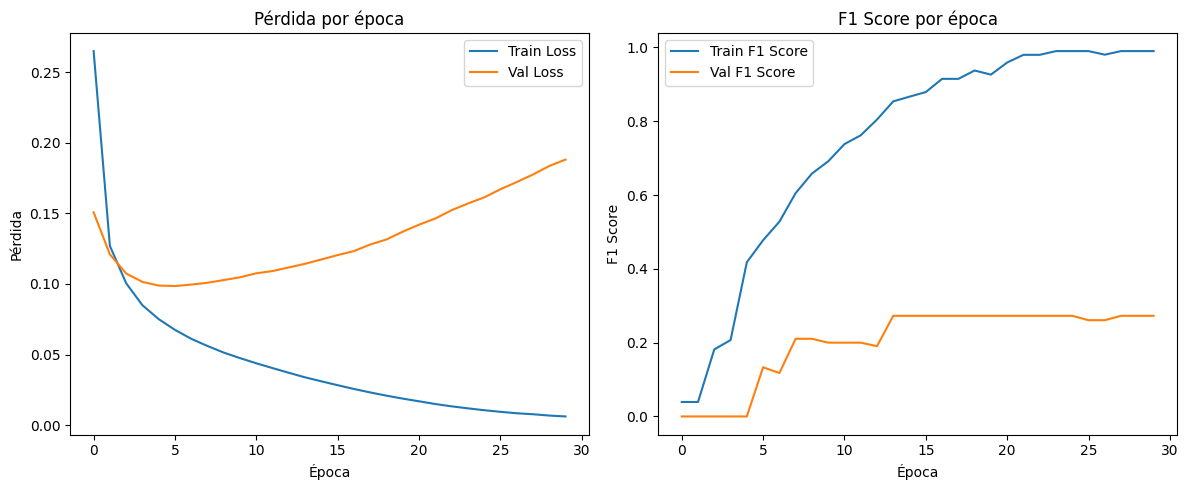

In [68]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, roc_auc_score

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Definir modelo base
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Inicializar listas para F1 y AUC por época
train_f1_scores = []
val_f1_scores = []

# Entrenamiento manual por época para registrar F1 en cada una
epochs = 30
batch_size = 32
history = {'loss': [], 'val_loss': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Entrenar una época
    hist = model.fit(X_train_sub, y_train,
                     validation_data=(X_valid_sub, y_val),
                     epochs=1,
                     batch_size=batch_size,
                     verbose=0)

    # Guardar pérdida
    history['loss'].append(hist.history['loss'][0])
    history['val_loss'].append(hist.history['val_loss'][0])

    # Predicciones entrenamiento
    train_proba = model.predict(X_train_sub, verbose=0)
    train_pred = (train_proba > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_pred)
    train_f1_scores.append(train_f1)

    # Predicciones validación
    val_proba = model.predict(X_valid_sub, verbose=0)
    val_pred = (val_proba > 0.5).astype(int)
    val_f1 = f1_score(y_val, val_pred)
    val_f1_scores.append(val_f1)

    print(f"Train F1: {round(train_f1, 4)} | Val F1: {round(val_f1, 4)}")

# Calcular métricas finales en validación
final_val_auc = roc_auc_score(y_val, val_proba)
final_val_f1 = f1_score(y_val, val_pred)
print(f"\nFinal Validation F1 Score: {round(final_val_f1, 4)}")
print(f"Final Validation AUC Score: {round(final_val_auc, 4)}")

# Graficar pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Graficar F1 Scores
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.title("F1 Score por época")
plt.xlabel("Época")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

# Predicción final en test
#test_predictions = model.predict(X_test_scaled)


Hay sobreajuste


Epoch 1/30
Train F1: 0.0 | Val F1: 0.0

Epoch 2/30
Train F1: 0.0 | Val F1: 0.0

Epoch 3/30
Train F1: 0.0 | Val F1: 0.0

Epoch 4/30
Train F1: 0.0 | Val F1: 0.0

Epoch 5/30
Train F1: 0.0392 | Val F1: 0.0

Epoch 6/30
Train F1: 0.0769 | Val F1: 0.0

Epoch 7/30
Train F1: 0.1818 | Val F1: 0.0

Epoch 8/30
Train F1: 0.2456 | Val F1: 0.0

Epoch 9/30
Train F1: 0.2456 | Val F1: 0.0

Epoch 10/30
Train F1: 0.2143 | Val F1: 0.0

Epoch 11/30
Train F1: 0.2414 | Val F1: 0.0

Epoch 12/30
Train F1: 0.2414 | Val F1: 0.0

Epoch 13/30
Train F1: 0.2414 | Val F1: 0.0

Epoch 14/30
Train F1: 0.2105 | Val F1: 0.0

Epoch 15/30
Train F1: 0.2712 | Val F1: 0.0

Epoch 16/30
Train F1: 0.2712 | Val F1: 0.0

Epoch 17/30
Train F1: 0.2414 | Val F1: 0.0

Epoch 18/30
Train F1: 0.2712 | Val F1: 0.0

Epoch 19/30
Train F1: 0.3279 | Val F1: 0.0

Epoch 20/30
Train F1: 0.3279 | Val F1: 0.0

Epoch 21/30
Train F1: 0.3279 | Val F1: 0.0

Epoch 22/30
Train F1: 0.2712 | Val F1: 0.0

Epoch 23/30
Train F1: 0.3279 | Val F1: 0.0

Epoch 24

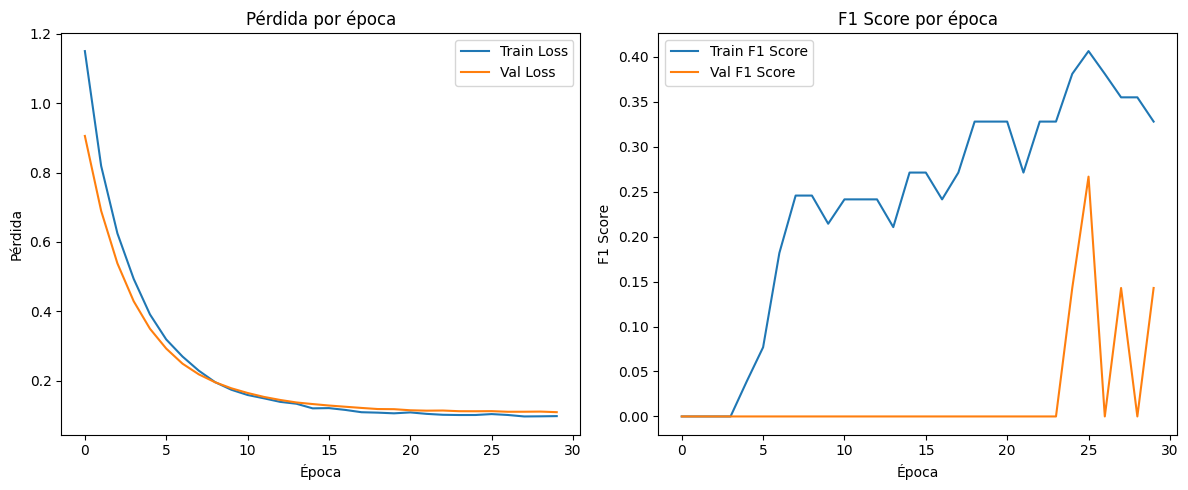

In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, roc_auc_score

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],), 
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Inicializar listas para F1 y AUC por época
train_f1_scores = []
val_f1_scores = []

# Entrenamiento manual por época para registrar F1 en cada una
epochs = 30
batch_size = 32
history = {'loss': [], 'val_loss': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Entrenar una época
    hist = model.fit(X_train_sub, y_train,
                     validation_data=(X_valid_sub, y_val),
                     epochs=1,
                     batch_size=batch_size,
                     verbose=0)

    # Guardar pérdida
    history['loss'].append(hist.history['loss'][0])
    history['val_loss'].append(hist.history['val_loss'][0])

    # Predicciones entrenamiento
    train_proba = model.predict(X_train_sub, verbose=0)
    train_pred = (train_proba > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_pred)
    train_f1_scores.append(train_f1)

    # Predicciones validación
    val_proba = model.predict(X_valid_sub, verbose=0)
    val_pred = (val_proba > 0.5).astype(int)
    val_f1 = f1_score(y_val, val_pred)
    val_f1_scores.append(val_f1)

    print(f"Train F1: {round(train_f1, 4)} | Val F1: {round(val_f1, 4)}")

# Calcular métricas finales en validación
final_val_auc = roc_auc_score(y_val, val_proba)
final_val_f1 = f1_score(y_val, val_pred)
print(f"\nFinal Validation F1 Score: {round(final_val_f1, 4)}")
print(f"Final Validation AUC Score: {round(final_val_auc, 4)}")

# Graficar pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Graficar F1 Scores
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.title("F1 Score por época")
plt.xlabel("Época")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


#### Predicción en X_test

In [70]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

# Subconjunto de datos con esas variables
X_test_sub = X_test_scaled_df[selected_features]

# Predicción final en test
test_predictions = model.predict(X_test_sub)

16/16 [==============================] - 0s 800us/step


In [71]:
# El ID está en una columna llamada 'ID'
submission_df = pd.DataFrame({
    'ID': test['ID'],
    'Bankruptcy': test_predictions.flatten()
})

# Guardar el archivo correctamente
submission_df.to_csv("submission_SF1.csv", index=False)

# Verificar
submission_df.head()

,ID,Bankruptcy
0,5,0.002575
1,14,0.143134
2,16,0.015097
3,26,0.016307
4,28,0.004442


#### Umbral de 9: Descartado -> Mas bajo AUC

In [13]:
# Filtrar las variables que superan el umbral de 9 de importancia
threshold = 9
selected_features = importance_df[importance_df['weight_importance'] > threshold]['feature_name'].tolist()

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train_imputed.columns)

# Subconjunto de datos con esas variables
X_train_sub = X_train_scaled_df[selected_features]
X_valid_sub = X_val_scaled_df[selected_features]

# Aplicar SMOTE para balancear clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_sub, y_train)


Epoch 1/50
Train F1: 0.0 | Val F1: 0.0

Epoch 2/50
Train F1: 0.0 | Val F1: 0.0

Epoch 3/50
Train F1: 0.0 | Val F1: 0.0

Epoch 4/50
Train F1: 0.0 | Val F1: 0.0

Epoch 5/50
Train F1: 0.0 | Val F1: 0.0

Epoch 6/50
Train F1: 0.0 | Val F1: 0.0

Epoch 7/50
Train F1: 0.0 | Val F1: 0.0

Epoch 8/50
Train F1: 0.0 | Val F1: 0.0

Epoch 9/50
Train F1: 0.0392 | Val F1: 0.0

Epoch 10/50
Train F1: 0.0392 | Val F1: 0.0

Epoch 11/50
Train F1: 0.0385 | Val F1: 0.0

Epoch 12/50
Train F1: 0.0755 | Val F1: 0.0

Epoch 13/50
Train F1: 0.0392 | Val F1: 0.0

Epoch 14/50
Train F1: 0.0755 | Val F1: 0.0

Epoch 15/50
Train F1: 0.1455 | Val F1: 0.0

Epoch 16/50
Train F1: 0.0755 | Val F1: 0.0

Epoch 17/50
Train F1: 0.0755 | Val F1: 0.0

Epoch 18/50
Train F1: 0.1786 | Val F1: 0.0

Epoch 19/50
Train F1: 0.2105 | Val F1: 0.0

Epoch 20/50
Train F1: 0.2105 | Val F1: 0.0

Epoch 21/50
Train F1: 0.1786 | Val F1: 0.0

Epoch 22/50
Train F1: 0.1786 | Val F1: 0.0

Epoch 23/50
Train F1: 0.1786 | Val F1: 0.0

Epoch 24/50
Train F1

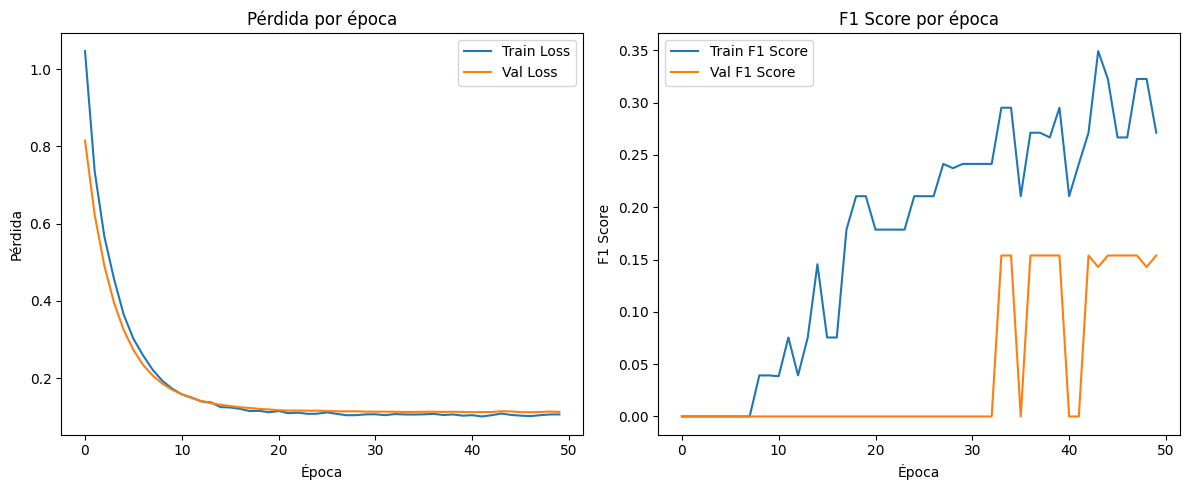

In [16]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, roc_auc_score

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],), 
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Inicializar listas para F1 y AUC por época
train_f1_scores = []
val_f1_scores = []

# Entrenamiento manual por época para registrar F1 en cada una
epochs = 50
batch_size = 32
history = {'loss': [], 'val_loss': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Entrenar una época
    hist = model.fit(X_train_sub, y_train,
                     validation_data=(X_valid_sub, y_val),
                     epochs=1,
                     batch_size=batch_size,
                     verbose=0)

    # Guardar pérdida
    history['loss'].append(hist.history['loss'][0])
    history['val_loss'].append(hist.history['val_loss'][0])

    # Predicciones entrenamiento
    train_proba = model.predict(X_train_sub, verbose=0)
    train_pred = (train_proba > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_pred)
    train_f1_scores.append(train_f1)

    # Predicciones validación
    val_proba = model.predict(X_valid_sub, verbose=0)
    val_pred = (val_proba > 0.5).astype(int)
    val_f1 = f1_score(y_val, val_pred)
    val_f1_scores.append(val_f1)

    print(f"Train F1: {round(train_f1, 4)} | Val F1: {round(val_f1, 4)}")

# Calcular métricas finales en validación
final_val_auc = roc_auc_score(y_val, val_proba)
final_val_f1 = f1_score(y_val, val_pred)
print(f"\nFinal Validation F1 Score: {round(final_val_f1, 4)}")
print(f"Final Validation AUC Score: {round(final_val_auc, 4)}")

# Graficar pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Graficar F1 Scores
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.title("F1 Score por época")
plt.xlabel("Época")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
#### Predicción en X_test
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

# Subconjunto de datos con esas variables
X_test_sub = X_test_scaled_df[selected_features]

# Predicción final en test
test_predictions = model.predict(X_test_sub)
# El ID está en una columna llamada 'ID'
submission_df = pd.DataFrame({
    'ID': test['ID'],
    'Bankruptcy': test_predictions.flatten()
})

# Guardar el archivo correctamente
submission_df.to_csv("../results/submission_SF2.csv", index=False)

# Verificar
submission_df.head()

16/16 [==============================] - 0s 867us/step


,ID,Bankruptcy
0,5,0.001810
1,14,0.123997
2,16,0.024367
3,26,0.010376
4,28,0.008631


### Ajuste de la red neuronal

In [31]:
import keras_tuner as kt
import os
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Definir el modelo de Keras con los hiperparámetros a ajustar
def build_model(hp):
    model = models.Sequential()
    
    # Primera capa densa (ajuste de hiperparámetros para el número de unidades y la regularización L2)
    model.add(layers.Dense(
        hp.Int('units_1', min_value=32, max_value=128, step=32), 
        activation='relu', 
        input_shape=(X_train_sub.shape[1],),
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_1', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Segunda capa densa
    model.add(layers.Dense(
        hp.Int('units_2', min_value=32, max_value=128, step=32), 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_2', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Capa de salida
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compilación del modelo
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

output_dir = 'C:/Users/Usuario/OneDrive - Universidad de los andes\MIAD\C8_2_Deep_Learning\Miniproyecto_Bancarrota/Proyecto_Bancarrota_DeepLearning/scripts/hyperpar'
os.makedirs(output_dir, exist_ok=True)

# Definir el tuner
tuner = kt.Hyperband(
    build_model,  # función que define el modelo
    objective='val_accuracy',  # métrica a optimizar
    max_epochs=100,  # número máximo de épocas para cada prueba
    hyperband_iterations=2,  # número de pruebas de Hyperband
    directory=output_dir,  # directorio para almacenar resultados
    project_name='tune_model'  # nombre del proyecto
)

# Realizar la búsqueda de hiperparámetros
tuner.search(
    X_train_sub, y_train,  # datos de entrenamiento
    epochs=100,  # épocas para cada búsqueda
    validation_data=(X_valid_sub, y_val)  # datos de validación
)

# Obtener los mejores hiperparámetros
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Mejores hiperparámetros encontrados:", best_hyperparameters.values)

# Entrenar el modelo con los mejores hiperparámetros encontrados
best_model = tuner.hypermodel.build(best_hyperparameters)

# Agregar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Ajustar las épocas como un hiperparámetro
epochs = best_hyperparameters['epochs'] if 'epochs' in best_hyperparameters else 50

# Entrenar con EarlyStopping y usando el valor de épocas ajustado
history = best_model.fit(
    X_train_sub, y_train,
    epochs=100,  # Usar el valor de épocas ajustado
    validation_data=(X_valid_sub, y_val),
    callbacks=[early_stopping]  # Agregar early stopping
)


Reloading Tuner from C:/Users/Usuario/OneDrive - Universidad de los andes\MIAD\C8_2_Deep_Learning\Miniproyecto_Bancarrota/Proyecto_Bancarrota_DeepLearning/scripts/hyperpar\tune_model\tuner0.json
Mejores hiperparámetros encontrados: {'units_1': 32, 'l2_reg_1': 3.3836290903560104e-05, 'dropout_1': 0.2, 'units_2': 128, 'l2_reg_2': 1.9765772376733028e-05, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.003070469702584253, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
Epoch 1/100
52/52 [==============================] - 1s 6ms/step - loss: 0.2507 - accuracy: 0.9293 - val_loss: 0.1140 - val_accuracy: 0.9707
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 0.1214 - accuracy: 0.9695 - val_loss: 0.1085 - val_accuracy: 0.9707
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 0.1041 - accuracy: 0.9695 - val_loss: 0.1030 - val_accuracy: 0.9707
Epoch 4/100
52/52 [=====================

13/13 [==============================] - 0s 926us/step


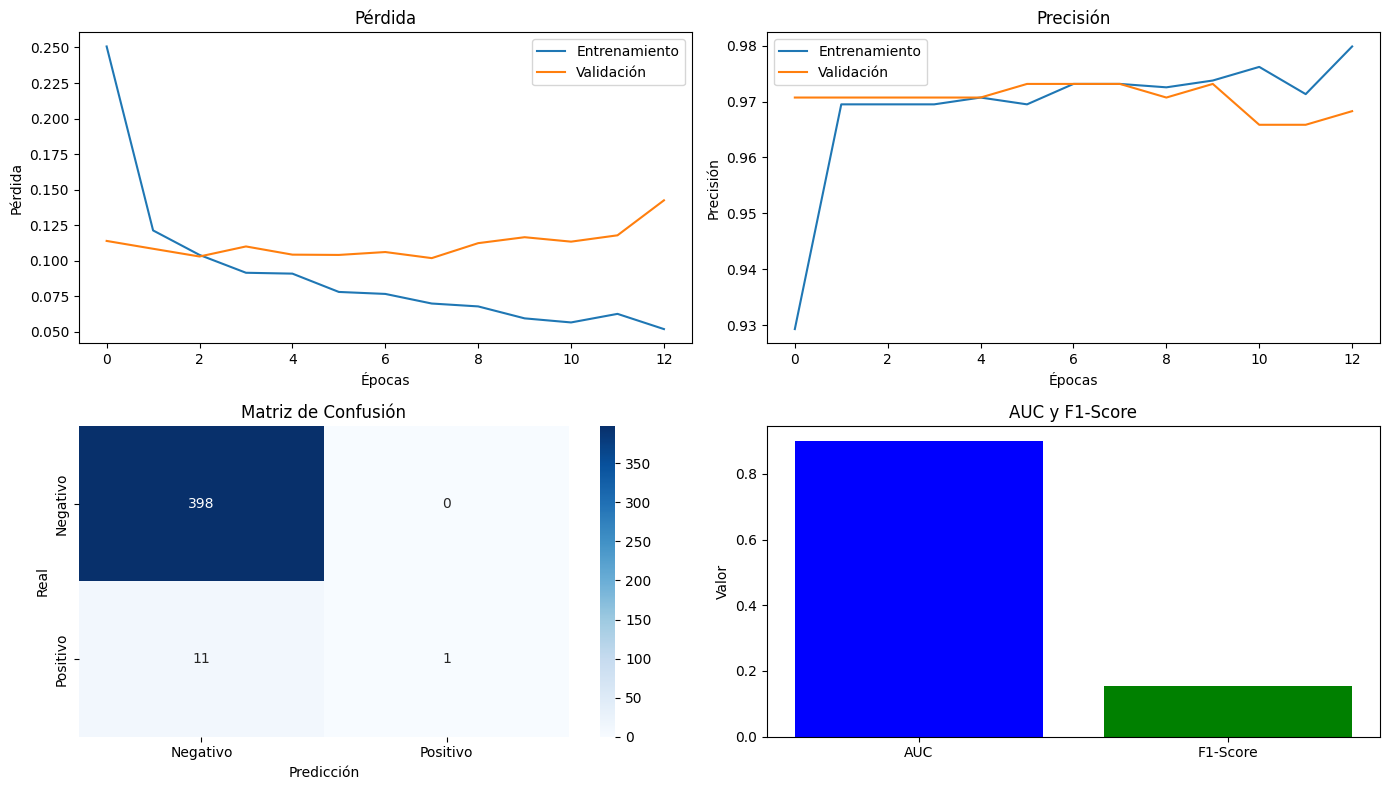

AUC: 0.9010
F1-Score: 0.1538


In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import seaborn as sns
import numpy as np

# Obtener las predicciones del modelo para calcular las métricas
y_pred = best_model.predict(X_valid_sub)

# Calcular las métricas
y_pred_bin = (y_pred > 0.5)  # Convertir las predicciones en valores binarios (0 o 1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred_bin)

# AUC
auc = roc_auc_score(y_val, y_pred)

# F1-Score
f1 = f1_score(y_val, y_pred_bin)

# Extraer los valores de loss y accuracy para entrenamiento y validación
history_dict = history.history

# Graficar la pérdida y precisión
plt.figure(figsize=(14, 8))

# Pérdida
plt.subplot(2, 2, 1)
plt.plot(history_dict['loss'], label='Entrenamiento')
plt.plot(history_dict['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(2, 2, 2)
plt.plot(history_dict['accuracy'], label='Entrenamiento')
plt.plot(history_dict['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')

# AUC y F1-Score
plt.subplot(2, 2, 4)
metrics = ['AUC', 'F1-Score']
values = [auc, f1]
plt.bar(metrics, values, color=['blue', 'green'])
plt.title('AUC y F1-Score')
plt.ylabel('Valor')

plt.tight_layout()
plt.show()

# Imprimir AUC y F1-Score
print(f'AUC: {auc:.4f}')
print(f'F1-Score: {f1:.4f}')


In [33]:
# Predicción final en el conjunto de test
test_predictions = best_model.predict(X_test_sub)  # Realiza las predicciones sobre el conjunto de prueba

# Crear un DataFrame con las predicciones y los IDs
submission_df = pd.DataFrame({
    'ID': test['ID'],  # Asumiendo que el DataFrame 'test' tiene la columna 'ID'
    'Bankruptcy': test_predictions.flatten()  # Flatten para asegurar que sea un vector 1D
})

# Guardar el archivo correctamente
submission_df.to_csv("../results/submission_SF3_turner.csv", index=False)

# Verificar el archivo creado
submission_df.head()

16/16 [==============================] - 0s 867us/step


,ID,Bankruptcy
0,5,0.000010
1,14,0.031148
2,16,0.000465
3,26,0.019637
4,28,0.000311


#### Ajuste manual

In [ ]:
Mejores parámetros: {'num_neurons': 64, 'learning_rate': 0.001, 'l2_reg': 0.01, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 64}

In [46]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],), 
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [49]:
# Entrenamiento del modelo
history = model.fit(X_train_sub, y_train,
                    validation_data=(X_valid_sub, y_val),
                    epochs=30,
                    batch_size=32,
                    verbose=1)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(X_valid_sub, y_val, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/30
52/52 [==============================] - 0s 3ms/step - loss: 0.1021 - accuracy: 0.9720 - val_loss: 0.1137 - val_accuracy: 0.9732
Epoch 2/30
52/52 [==============================] - 0s 2ms/step - loss: 0.1006 - accuracy: 0.9744 - val_loss: 0.1146 - val_accuracy: 0.9707
Epoch 3/30
52/52 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9732 - val_loss: 0.1132 - val_accuracy: 0.9732
Epoch 4/30
52/52 [==============================] - 0s 2ms/step - loss: 0.1046 - accuracy: 0.9707 - val_loss: 0.1142 - val_accuracy: 0.9707
Epoch 5/30
52/52 [==============================] - 0s 2ms/step - loss: 0.1038 - accuracy: 0.9720 - val_loss: 0.1139 - val_accuracy: 0.9707
Epoch 6/30
52/52 [==============================] - 0s 2ms/step - loss: 0.1036 - accuracy: 0.9720 - val_loss: 0.1126 - val_accuracy: 0.9732
Epoch 7/30
52/52 [==============================] - 0s 2ms/step - loss: 0.1038 - accuracy: 0.9713 - val_loss: 0.1117 - val_accuracy: 0.9707
Epoch 8/30
52/52 [==

Epoch 1/50
52/52 [==============================] - 0s 3ms/step - loss: 0.1051 - accuracy: 0.9707 - val_loss: 0.1125 - val_accuracy: 0.9732
Epoch 2/50
52/52 [==============================] - 0s 2ms/step - loss: 0.0991 - accuracy: 0.9738 - val_loss: 0.1146 - val_accuracy: 0.9732
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 0.0936 - accuracy: 0.9756 - val_loss: 0.1158 - val_accuracy: 0.9732
Epoch 4/50
52/52 [==============================] - 0s 2ms/step - loss: 0.1006 - accuracy: 0.9732 - val_loss: 0.1153 - val_accuracy: 0.9707
Epoch 5/50
52/52 [==============================] - 0s 2ms/step - loss: 0.0997 - accuracy: 0.9744 - val_loss: 0.1137 - val_accuracy: 0.9732
Epoch 6/50
52/52 [==============================] - 0s 2ms/step - loss: 0.1016 - accuracy: 0.9713 - val_loss: 0.1136 - val_accuracy: 0.9659
Epoch 7/50
52/52 [==============================] - 0s 2ms/step - loss: 0.1031 - accuracy: 0.9744 - val_loss: 0.1139 - val_accuracy: 0.9707
Epoch 8/50
52/52 [==

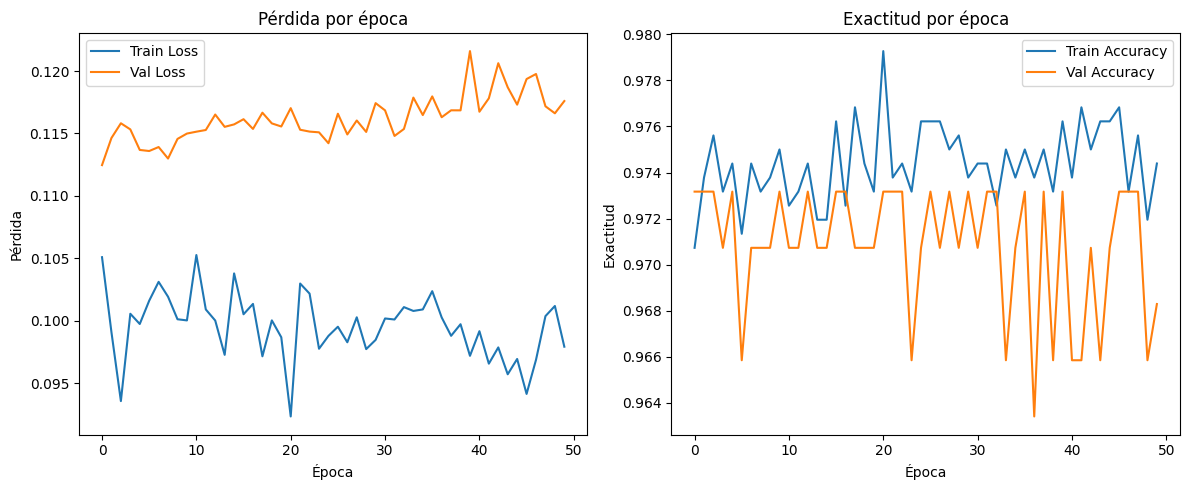

In [50]:
# Entrenamiento del modelo y registro de métricas
history = model.fit(X_train_sub, y_train,
                    validation_data=(X_valid_sub, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

# Calcular métricas adicionales al final del entrenamiento
train_proba = model.predict(X_train_sub)
val_proba = model.predict(X_valid_sub)

# Convertir probabilidades a predicciones binarias
train_pred = (train_proba > 0.5).astype(int)
val_pred = (val_proba > 0.5).astype(int)

# Calcular F1-score y AUC
train_f1 = f1_score(y_train, train_pred)
val_f1 = f1_score(y_val, val_pred)
train_auc = roc_auc_score(y_train, train_proba)
val_auc = roc_auc_score(y_val, val_proba)

print(f"Train F1 Score: {train_f1:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Graficar pérdida y exactitud por época
plt.figure(figsize=(12, 5))

# Graficar Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Graficar Exactitud
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Exactitud por época")
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100
Train F1: 0.0537 | Val F1: 0.0889

Epoch 2/100
Train F1: 0.0502 | Val F1: 0.0345

Epoch 3/100
Train F1: 0.0 | Val F1: 0.0741

Epoch 4/100
Train F1: 0.0 | Val F1: 0.125

Epoch 5/100
Train F1: 0.0 | Val F1: 0.0

Epoch 6/100
Train F1: 0.0 | Val F1: 0.0

Epoch 7/100
Train F1: 0.0 | Val F1: 0.0

Epoch 8/100
Train F1: 0.0 | Val F1: 0.0

Epoch 9/100
Train F1: 0.0 | Val F1: 0.0

Epoch 10/100
Train F1: 0.0 | Val F1: 0.0

Epoch 11/100
Train F1: 0.0 | Val F1: 0.0

Epoch 12/100
Train F1: 0.0 | Val F1: 0.0

Epoch 13/100
Train F1: 0.0 | Val F1: 0.0

Epoch 14/100
Train F1: 0.0 | Val F1: 0.0

Epoch 15/100
Train F1: 0.0 | Val F1: 0.0

Epoch 16/100
Train F1: 0.0 | Val F1: 0.0

Epoch 17/100
Train F1: 0.0 | Val F1: 0.0

Epoch 18/100
Train F1: 0.0 | Val F1: 0.0

Epoch 19/100
Train F1: 0.0 | Val F1: 0.0

Epoch 20/100
Train F1: 0.0 | Val F1: 0.0

Epoch 21/100
Train F1: 0.0 | Val F1: 0.0

Epoch 22/100
Train F1: 0.0 | Val F1: 0.0

Epoch 23/100
Train F1: 0.0 | Val F1: 0.0

Epoch 24/100
Train F1: 0.

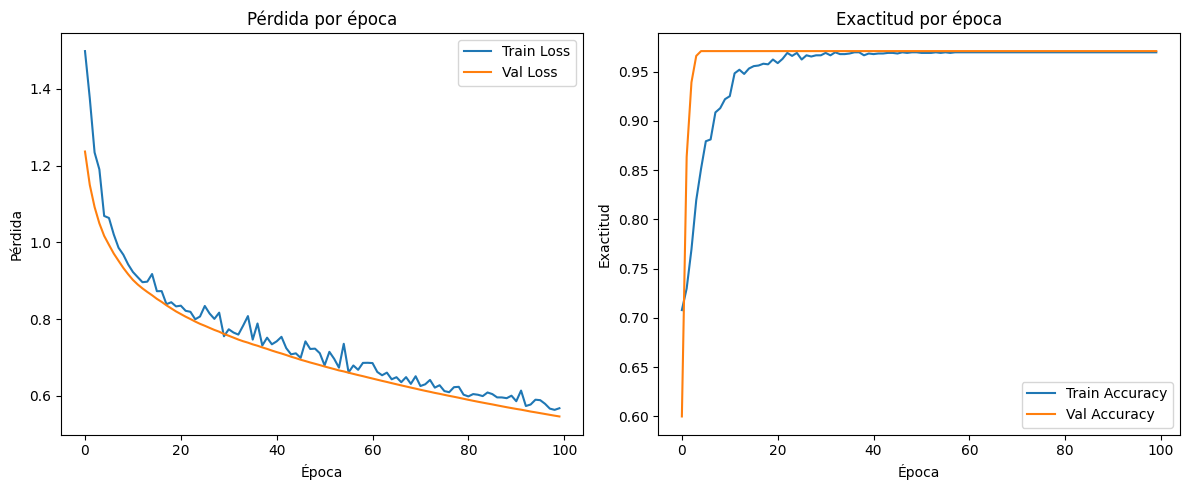

In [71]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, roc_auc_score
from keras.optimizers import SGD

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(40, activation='relu', input_shape=(X_train_sub.shape[1],),
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Disminuir L2 regularization
    layers.Dropout(0.8),  # Disminuir Dropout
    layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.8),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo con tasa de aprendizaje ajustada
#model.compile(optimizer=Adam(learning_rate=0.001),  # Ajuste de tasa de aprendizaje
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.5),  # Ajuste de tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Inicializar listas para F1 y AUC por época
train_f1_scores = []
val_f1_scores = []

# Entrenamiento manual por época para registrar F1 en cada una
epochs = 100
batch_size = 32
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Entrenar una época
    hist = model.fit(X_train_sub, y_train,
                     validation_data=(X_valid_sub, y_val),
                     epochs=1,
                     batch_size=batch_size,
                     verbose=0)

    # Guardar pérdida y exactitud
    history['loss'].append(hist.history['loss'][0])
    history['val_loss'].append(hist.history['val_loss'][0])
    history['accuracy'].append(hist.history['accuracy'][0])
    history['val_accuracy'].append(hist.history['val_accuracy'][0])

    # Predicciones entrenamiento
    train_proba = model.predict(X_train_sub, verbose=0)
    train_pred = (train_proba > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_pred)
    train_f1_scores.append(train_f1)

    # Predicciones validación
    val_proba = model.predict(X_valid_sub, verbose=0)
    val_pred = (val_proba > 0.5).astype(int)
    val_f1 = f1_score(y_val, val_pred)
    val_f1_scores.append(val_f1)

    print(f"Train F1: {round(train_f1, 4)} | Val F1: {round(val_f1, 4)}")

# Calcular métricas finales en validación
final_val_auc = roc_auc_score(y_val, val_proba)
final_val_f1 = f1_score(y_val, val_pred)
print(f"\nFinal Validation F1 Score: {round(final_val_f1, 4)}")
print(f"Final Validation AUC Score: {round(final_val_auc, 4)}")

# Graficar pérdida y exactitud
plt.figure(figsize=(12, 5))

# Graficar Pérdida
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Graficar Exactitud
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title("Exactitud por época")
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.legend()

plt.tight_layout()
plt.show()


In [72]:
# Predicción final en test
test_predictions = model.predict(X_test_sub)

# El ID está en una columna llamada 'ID'
submission_df = pd.DataFrame({
    'ID': test['ID'],
    'Bankruptcy': test_predictions.flatten()
})

# Guardar el archivo correctamente
submission_df.to_csv("../results/submission_SF13_manual.csv", index=False)

# Verificar
submission_df.head()

16/16 [==============================] - 0s 800us/step


,ID,Bankruptcy
0,5,0.114720
1,14,0.113288
2,16,0.125425
3,26,0.136374
4,28,0.094830
